In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.font_manager as fm
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
import random
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms


In [4]:
#千千数模 q群：947622850

In [5]:
# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei'] # 设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False 

# 加载字体文件
font = fm.FontProperties(fname='C:\Windows\Fonts\simhei.ttf', size=16)

# 2 考虑商超以品类为单位做补货计划，请分析各蔬菜品类的销售总量与成本加成定价的关系，并给出各蔬菜品类未来一周(2023 年 7 月 1-7 日)的日补货总量和定价策略，使得商超收益最大。

In [6]:
# Read the data
'''
# data_1: 6 个蔬菜品类的商品信息
# data_2: 销售流水明细数据
# data_3: 蔬菜类商品的批发价格
# data_4: 蔬菜类商品的近期损耗率
附件 1 中，部分单品名称包含的数字编号表示不同的供应来源。
附件 4 中的损耗率反映了近期商品的损耗情况，通过近期盘点周期的数据计算得到。

'''
data_1 = pd.read_excel('附件1.xlsx')
data_2 = pd.read_excel('附件2.xlsx')
data_3 = pd.read_excel('附件3.xlsx')
data_4 = pd.read_excel('附件4.xlsx')

In [7]:
data_1.head()

,单品编码,单品名称,分类编码,分类名称
0,102900005115168,牛首生菜,1011010101,花叶类
1,102900005115199,四川红香椿,1011010101,花叶类
2,102900005115625,本地小毛白菜,1011010101,花叶类
3,102900005115748,白菜苔,1011010101,花叶类
4,102900005115762,苋菜,1011010101,花叶类


In [8]:
data_2.head()

,销售日期,扫码销售时间,单品编码,销量(千克),销售单价(元/千克),销售类型,是否打折销售
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,销售,否
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,销售,否
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,销售,否
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,销售,否
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,销售,否


In [9]:
#将data_3中的列重命名为销售日期、单品编码和批发价格
data_3.columns = ['销售日期','单品编码','批发价格(元/千克)']
data_3.head()
#data_3.shape

,销售日期,单品编码,批发价格(元/千克)
0,2020-07-01,102900005115762,3.88
1,2020-07-01,102900005115779,6.72
2,2020-07-01,102900005115786,3.19
3,2020-07-01,102900005115793,9.24
4,2020-07-01,102900005115823,7.03


In [10]:
#将data_4中的列重命名为分类编码、分类名称、平均损耗率
data_4.columns = ['分类编码','分类名称','平均损耗率']
data_4.head()
#data_4.shape


,分类编码,分类名称,平均损耗率
0,1011010201,花菜类,15.51
1,1011010402,水生根茎类,13.65
2,1011010101,花叶类,12.83
3,1011010801,食用菌,9.45
4,1011010504,辣椒类,9.24


In [11]:
# 合并data_1和data_2
# 合并data_1、data_2、data_3和data_4
merged_data = pd.merge(data_1, data_2, on='单品编码')
merged_data = pd.merge(merged_data, data_3, on=['单品编码', '销售日期'])
merged_data = pd.merge(merged_data, data_4, on='分类编码')

In [12]:
# 删除掉merged_data中的分类名称_y列，并将分类名称_x列重命名为分类名称
merged_data.rename(columns={'分类名称_x': '分类名称'}, inplace=True)
merged_data.drop(columns=['分类名称_y'], inplace=True)
merged_data.head()

,单品编码,单品名称,分类编码,分类名称,销售日期,扫码销售时间,销量(千克),销售单价(元/千克),销售类型,是否打折销售,批发价格(元/千克),平均损耗率
0,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,10:02:13.748,0.743,5.0,销售,否,3.0,12.83
1,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,10:48:42.707,0.502,5.0,销售,否,3.0,12.83
2,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,11:10:13.023,0.301,5.0,销售,否,3.0,12.83
3,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,12:34:32.084,0.382,5.0,销售,否,3.0,12.83
4,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,13:33:59.748,0.261,5.0,销售,否,3.0,12.83


In [13]:
merged_data = pd.read_csv('merged_data.csv')
merged_data['销售日期'] = pd.to_datetime(merged_data['销售日期'])

In [14]:
merged_data = merged_data[(merged_data['销售类型'] == '销售') & (merged_data['是否打折销售'] == '否')]
merged_data.head()

,单品编码,单品名称,分类编码,分类名称,销售日期,扫码销售时间,销量(千克),销售单价(元/千克),销售类型,是否打折销售,批发价格(元/千克),平均损耗率
0,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,10:02:13.748,0.743,5.0,销售,否,3.0,12.83
1,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,10:48:42.707,0.502,5.0,销售,否,3.0,12.83
2,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,11:10:13.023,0.301,5.0,销售,否,3.0,12.83
3,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,12:34:32.084,0.382,5.0,销售,否,3.0,12.83
4,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,13:33:59.748,0.261,5.0,销售,否,3.0,12.83


# 2.1 以品类为单位对未来七天各蔬菜品类的批发价格进行预测

In [15]:
# 销售总量 = f(销售单价)
# 销售单价 = f(批发价格) + f(平均损耗率)
# 首先按照品类进行分组
# 首先按照单品和销售日期进行分组
grouped_data = merged_data.groupby(['分类名称','单品名称', '销售日期'])

# 计算每个单品每天的销售量和进货量
sales_by_item_day = grouped_data['销量(千克)'].sum()
purchase_by_item_day = grouped_data.apply(lambda x: ((1 + x['平均损耗率']/100) * x['销量(千克)']).sum())

# 计算每个单品每天的批发总价
wholesale_price_by_item_day = grouped_data.apply(lambda x: (x['批发价格(元/千克)'] * ((1 + x['平均损耗率']/100) * x['销量(千克)'])).sum())
# 计算每个单品每天的销售单价
sales_price_by_item_day = grouped_data.apply(lambda x: (x['销售单价(元/千克)'] * (x['销量(千克)'])).sum())

# 将结果合并为一个DataFrame
result = pd.concat([sales_by_item_day, purchase_by_item_day, wholesale_price_by_item_day, sales_price_by_item_day], axis=1)
result.columns = ['销售量', '进货量', '批发总价','销售总价']

In [16]:
result.head()

销售量       进货量       批发总价     销售总价
分类名称  单品名称  销售日期                                           
水生根茎类 净藕(1) 2020-07-08  8.239  9.363623  84.272612  131.824
            2020-07-10  6.206  7.053119  63.478071   99.296
            2020-07-11  5.942  6.753083  60.777747   95.072
            2020-07-12  8.260  9.387490  84.487410  132.160
            2020-07-13  7.956  9.041994  81.377946  127.296

In [17]:
avg_wholesale_price = result.groupby(['分类名称', '销售日期']).sum()['批发总价'] / result.groupby(['分类名称', '销售日期']).sum()['进货量']
avg_wholesale_price_1 = result.groupby(['分类名称', '销售日期']).sum()['销售总价'] / result.groupby(['分类名称', '销售日期']).sum()['销售量']
wholescale_num = result.groupby(['分类名称', '销售日期']).sum()['销售量']
# convert the grouped data into a dataframe and reset the index
avg_wholesale_price_df = avg_wholesale_price.reset_index()

# rename the columns
avg_wholesale_price_df.columns = ['分类名称', '销售日期', '平均批发价格']
avg_wholesale_price_df['平均销售价格'] = avg_wholesale_price_1.values
avg_wholesale_price_df['销售量'] = wholescale_num.values

# display the new dataframe
avg_wholesale_price_df.head(5)

,分类名称,销售日期,平均批发价格,平均销售价格,销售量
0,水生根茎类,2020-07-01,9.234161,14.491505,4.850
1,水生根茎类,2020-07-02,7.093748,11.548000,4.600
2,水生根茎类,2020-07-03,5.610000,10.000000,4.410
3,水生根茎类,2020-07-04,14.015119,21.833646,5.439
4,水生根茎类,2020-07-05,5.420000,10.000000,4.019


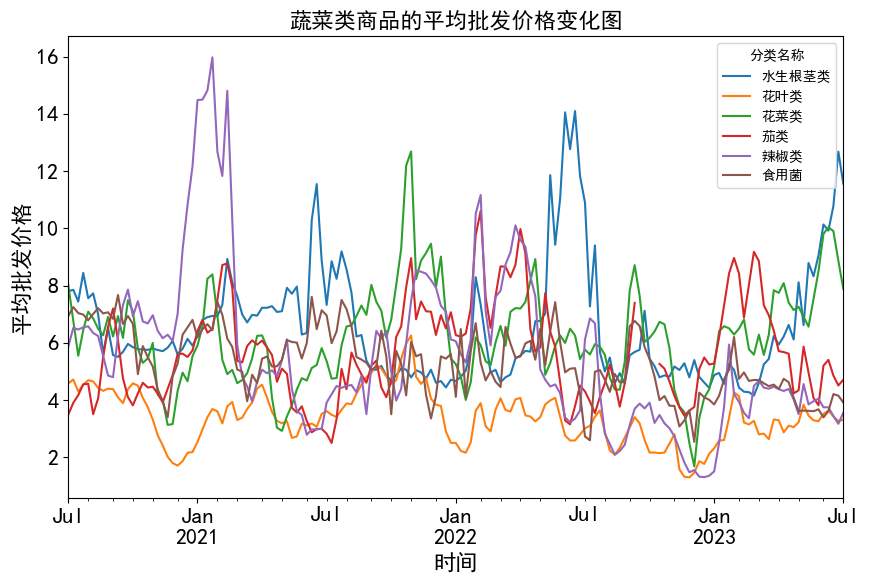

In [18]:
# 将销售日期转换为星期几
avg_wholesale_price_df['weekday'] = pd.to_datetime(avg_wholesale_price_df['销售日期']).dt.weekday

# 按照分类名称、星期几和周数进行分组，并计算平均批发价格
grouped_data = avg_wholesale_price_df.groupby(['分类名称', pd.Grouper(key='销售日期', freq='W-MON')])
avg_wholesale_price_by_category_week = grouped_data['平均批发价格'].mean()

# 将结果转换为DataFrame，并绘制折线图
result = avg_wholesale_price_by_category_week.unstack(level=0)
result.plot(kind='line', figsize=(10, 6), fontsize=16)
plt.xlabel('时间', fontproperties=font)
plt.ylabel('平均批发价格', fontproperties=font)
plt.title('蔬菜类商品的平均批发价格变化图', fontproperties=font)
plt.savefig('蔬菜类商品的平均批发价格变化图.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# 将销售日期转换为时间序列索引
avg_wholesale_price_df = avg_wholesale_price_df.set_index('销售日期')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimiza

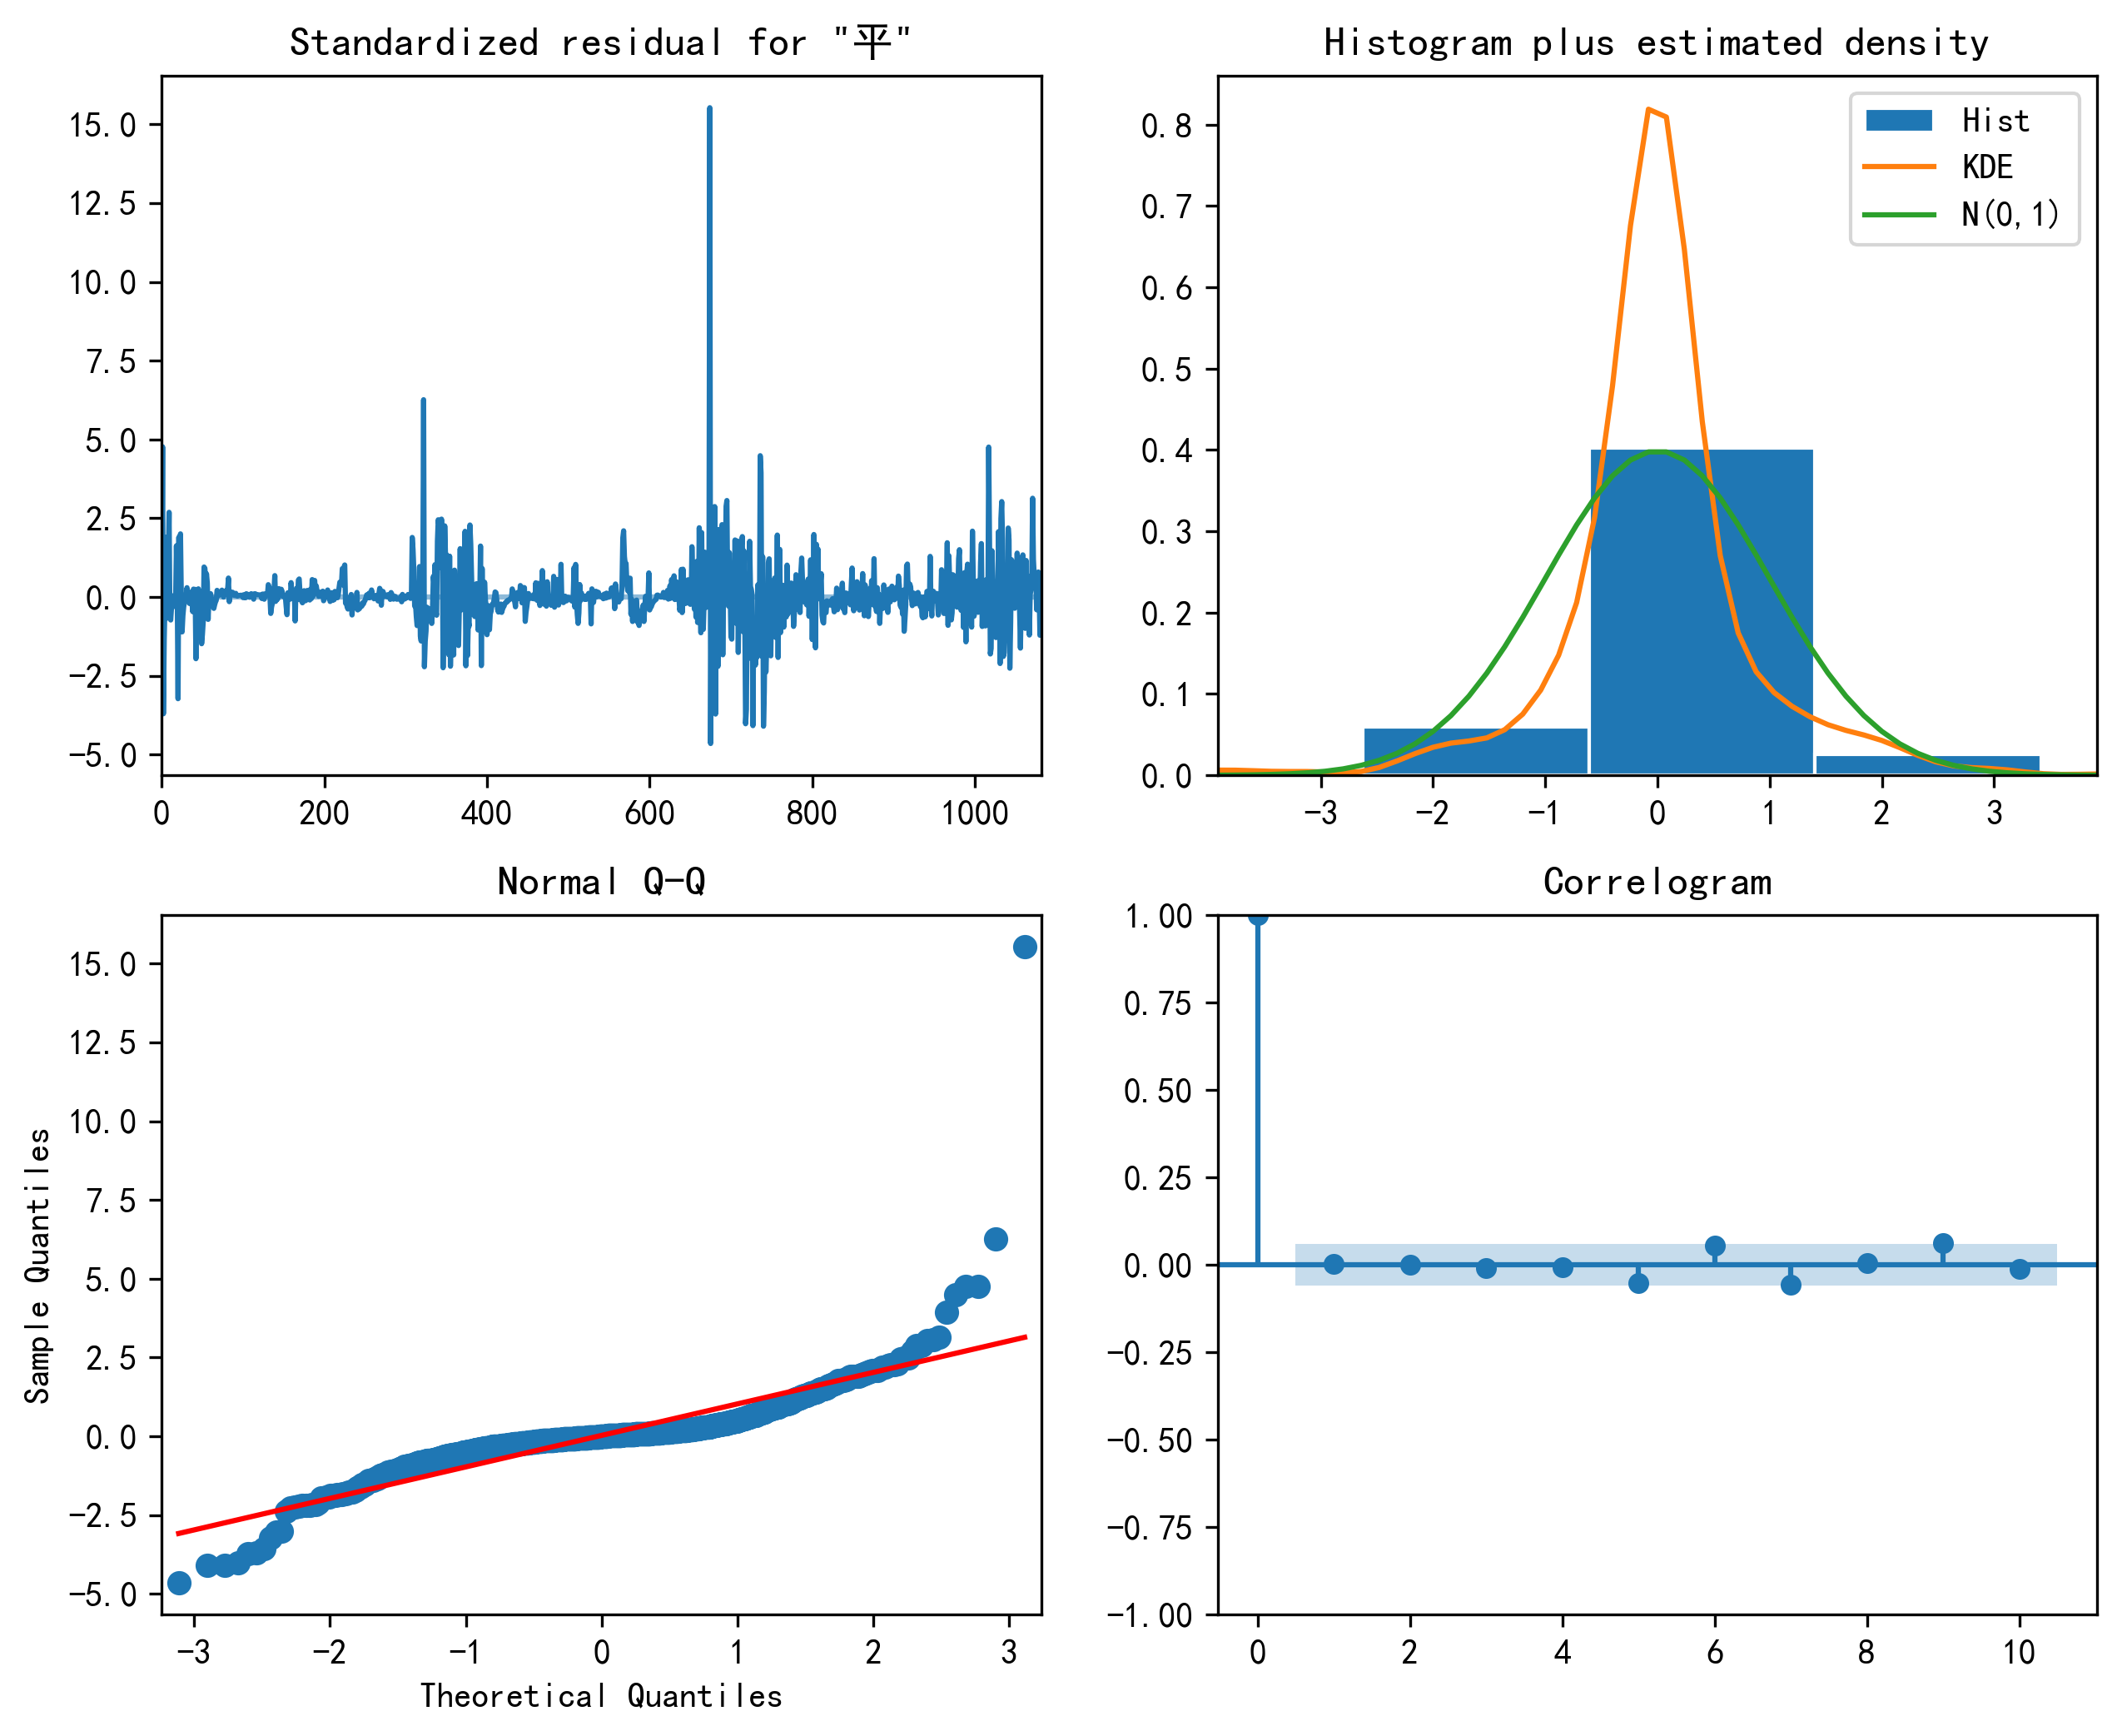

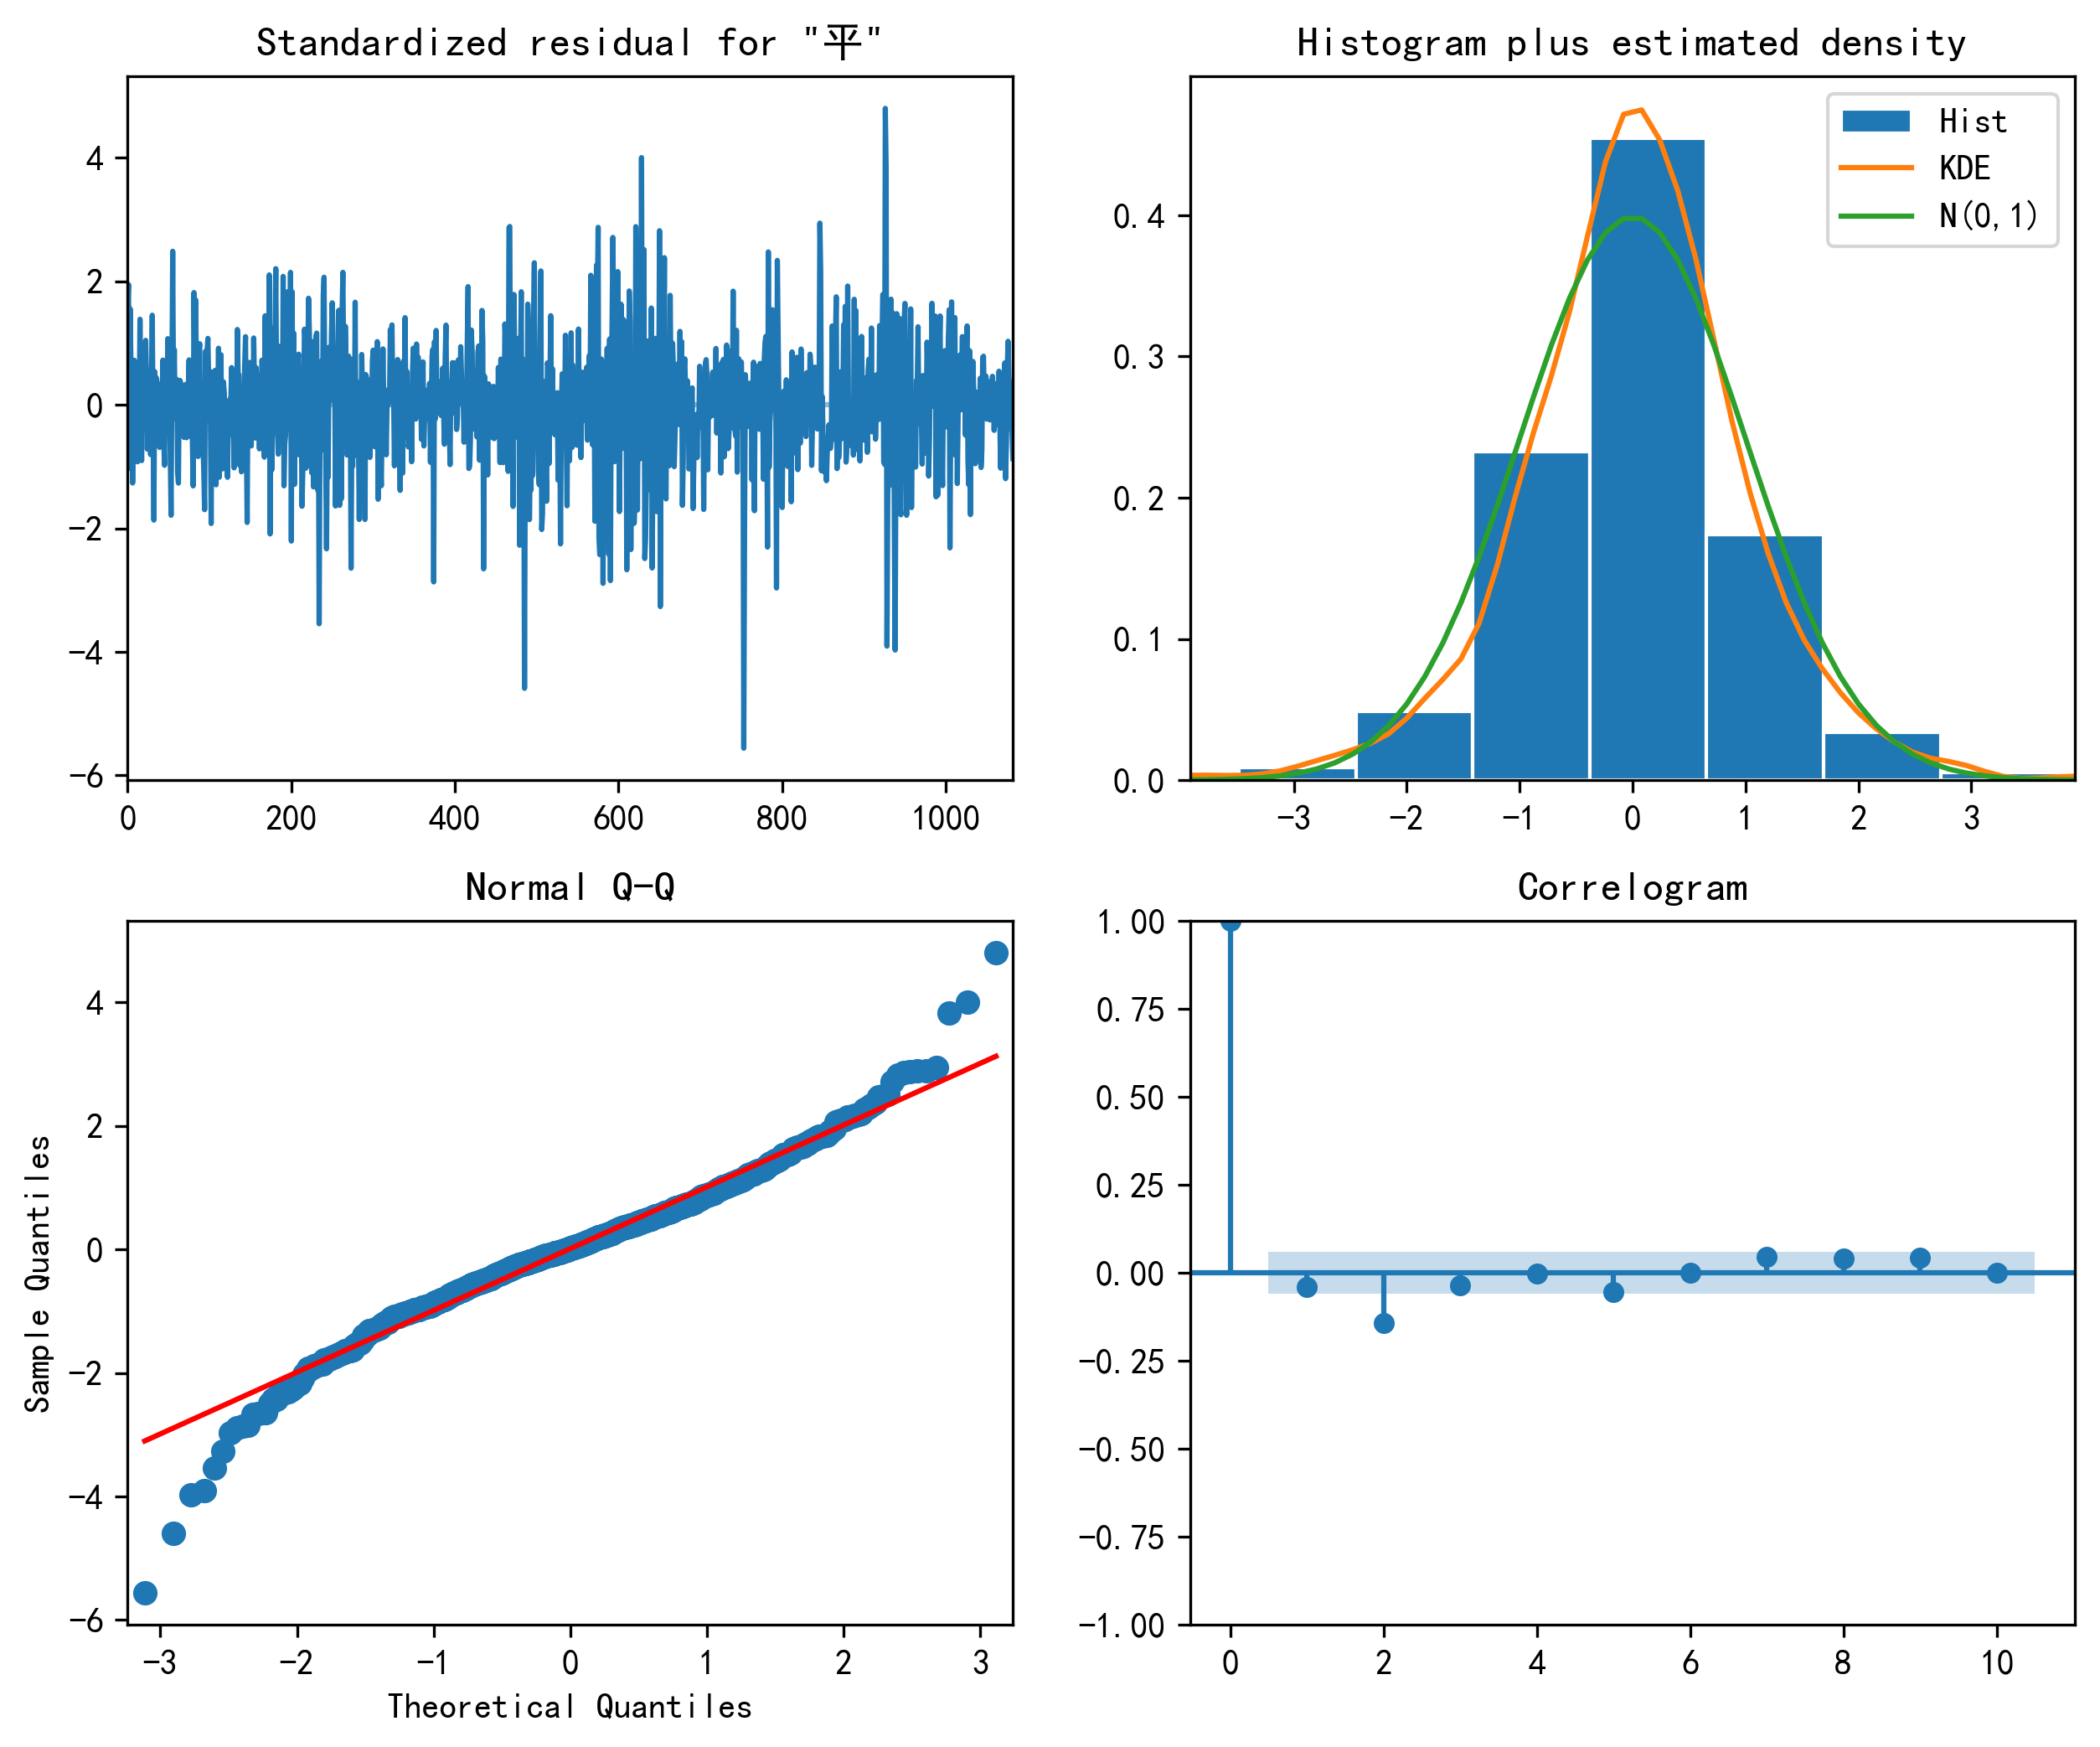

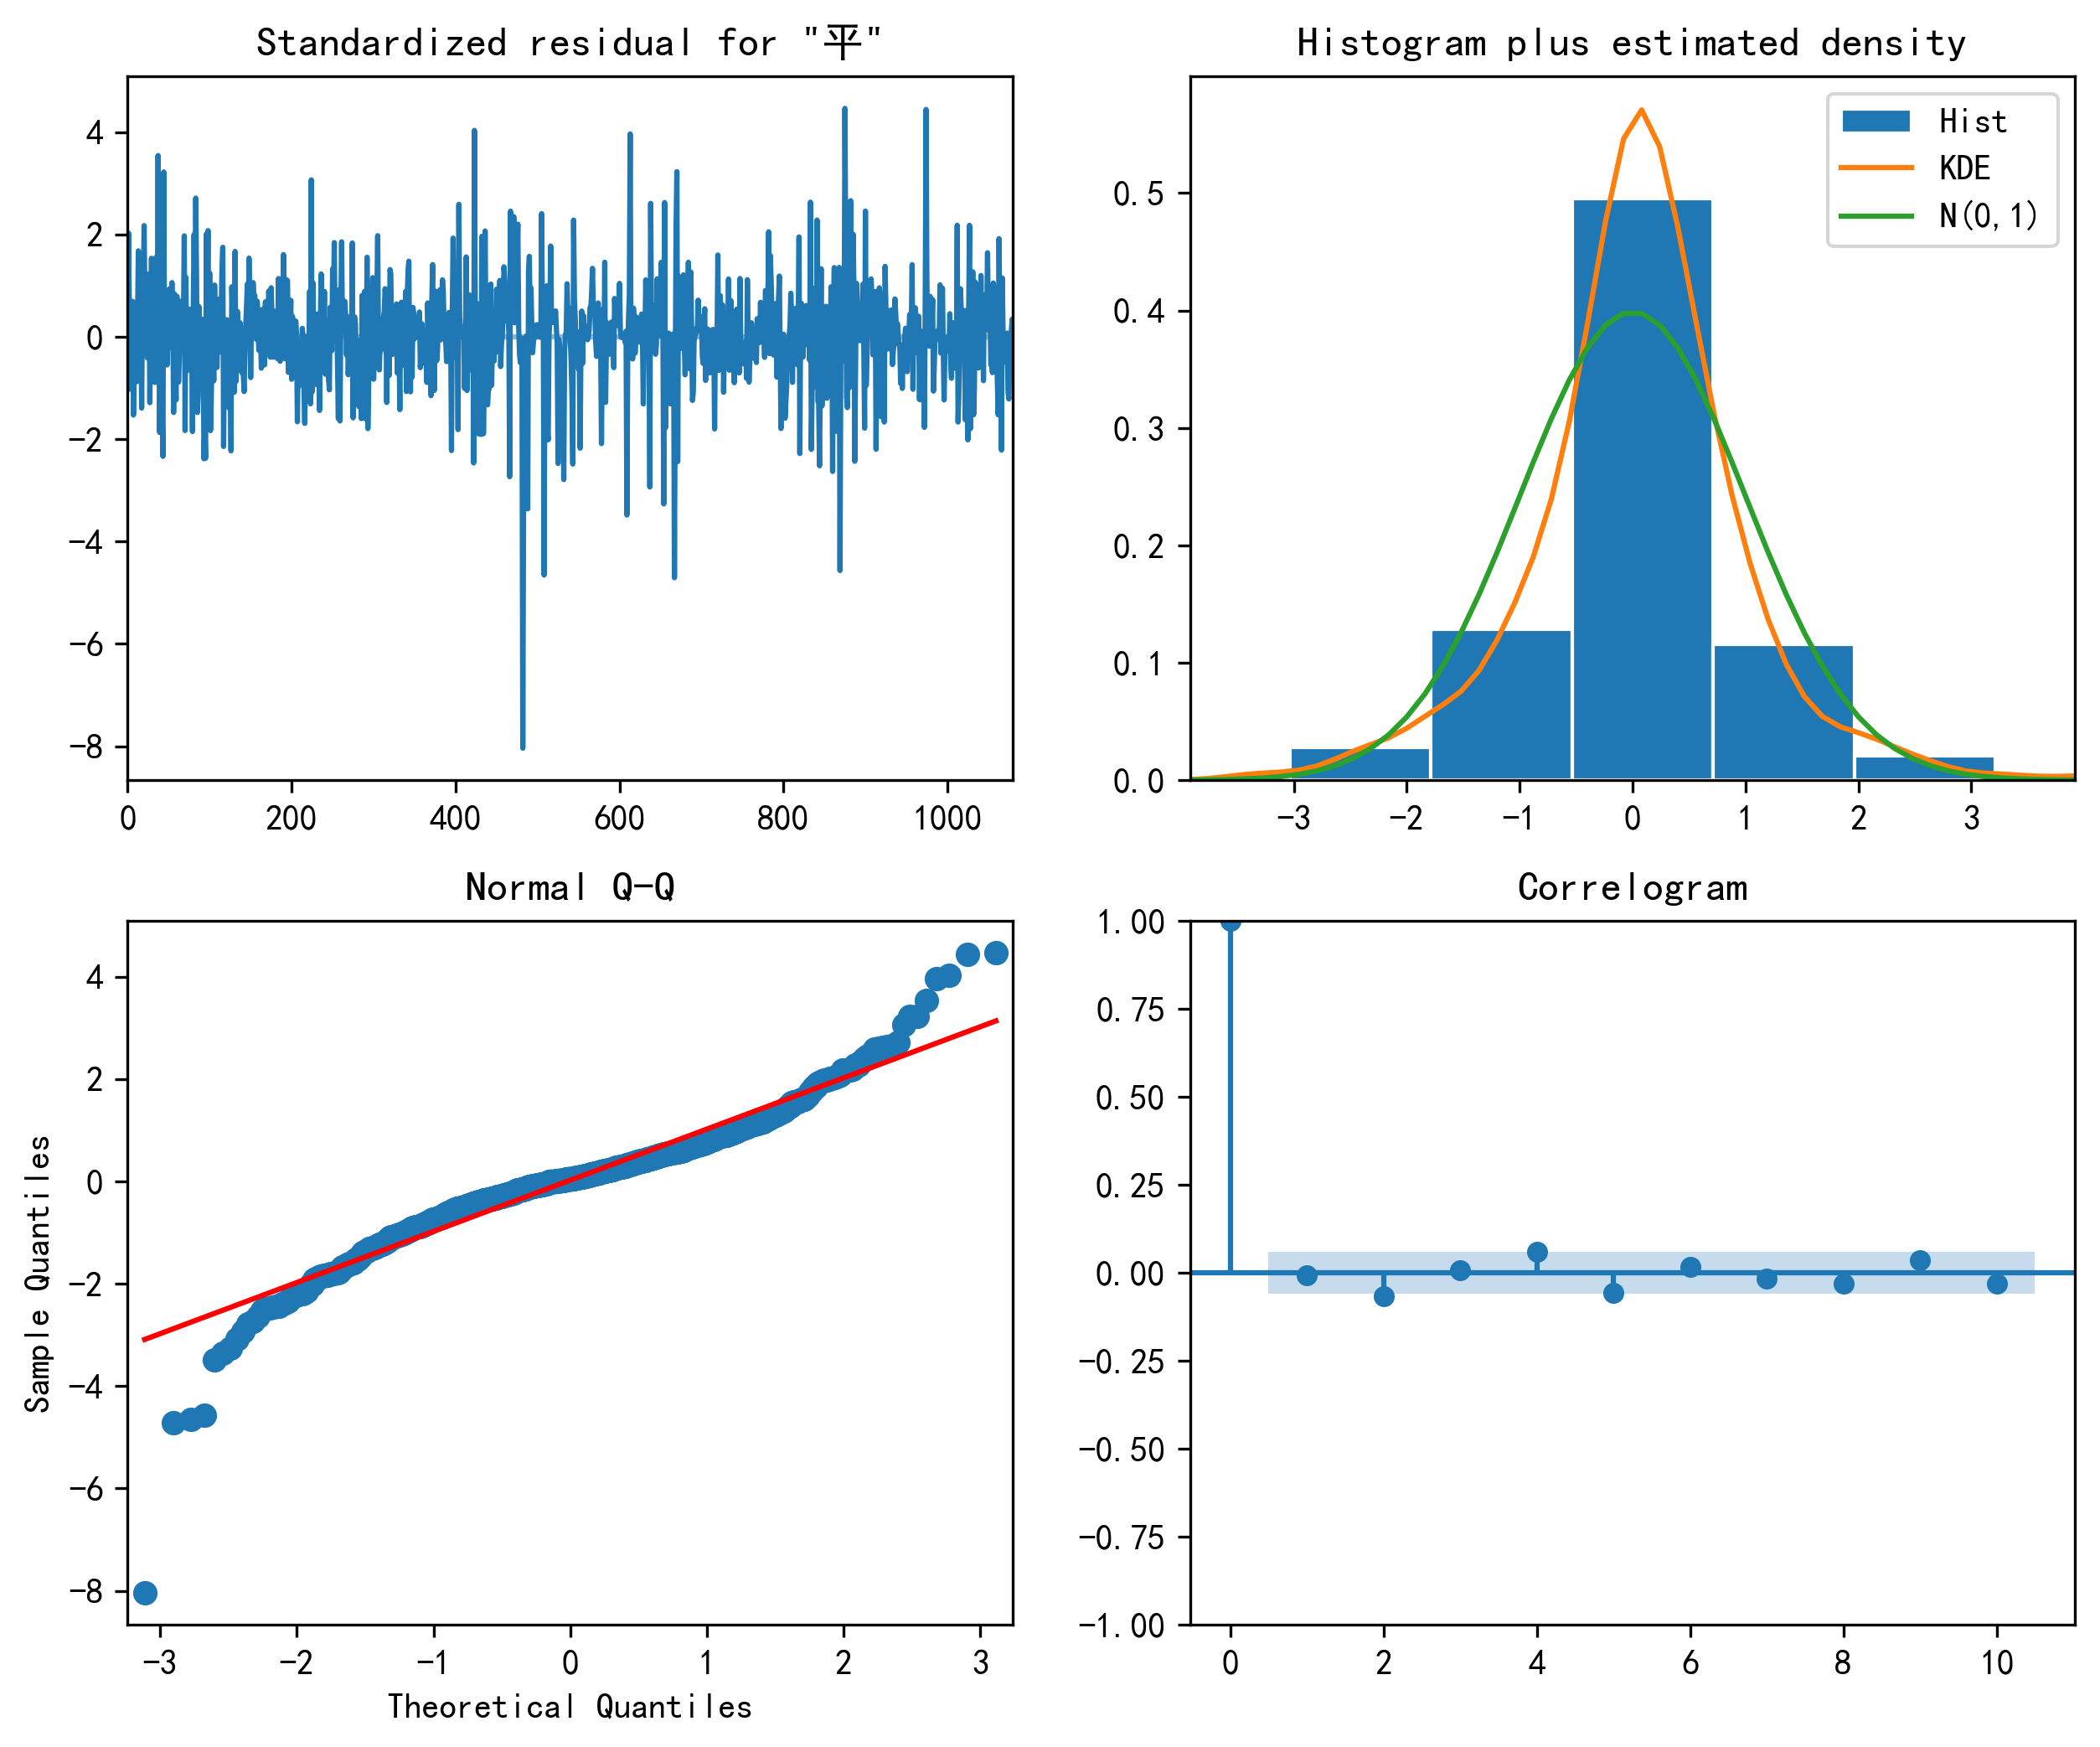

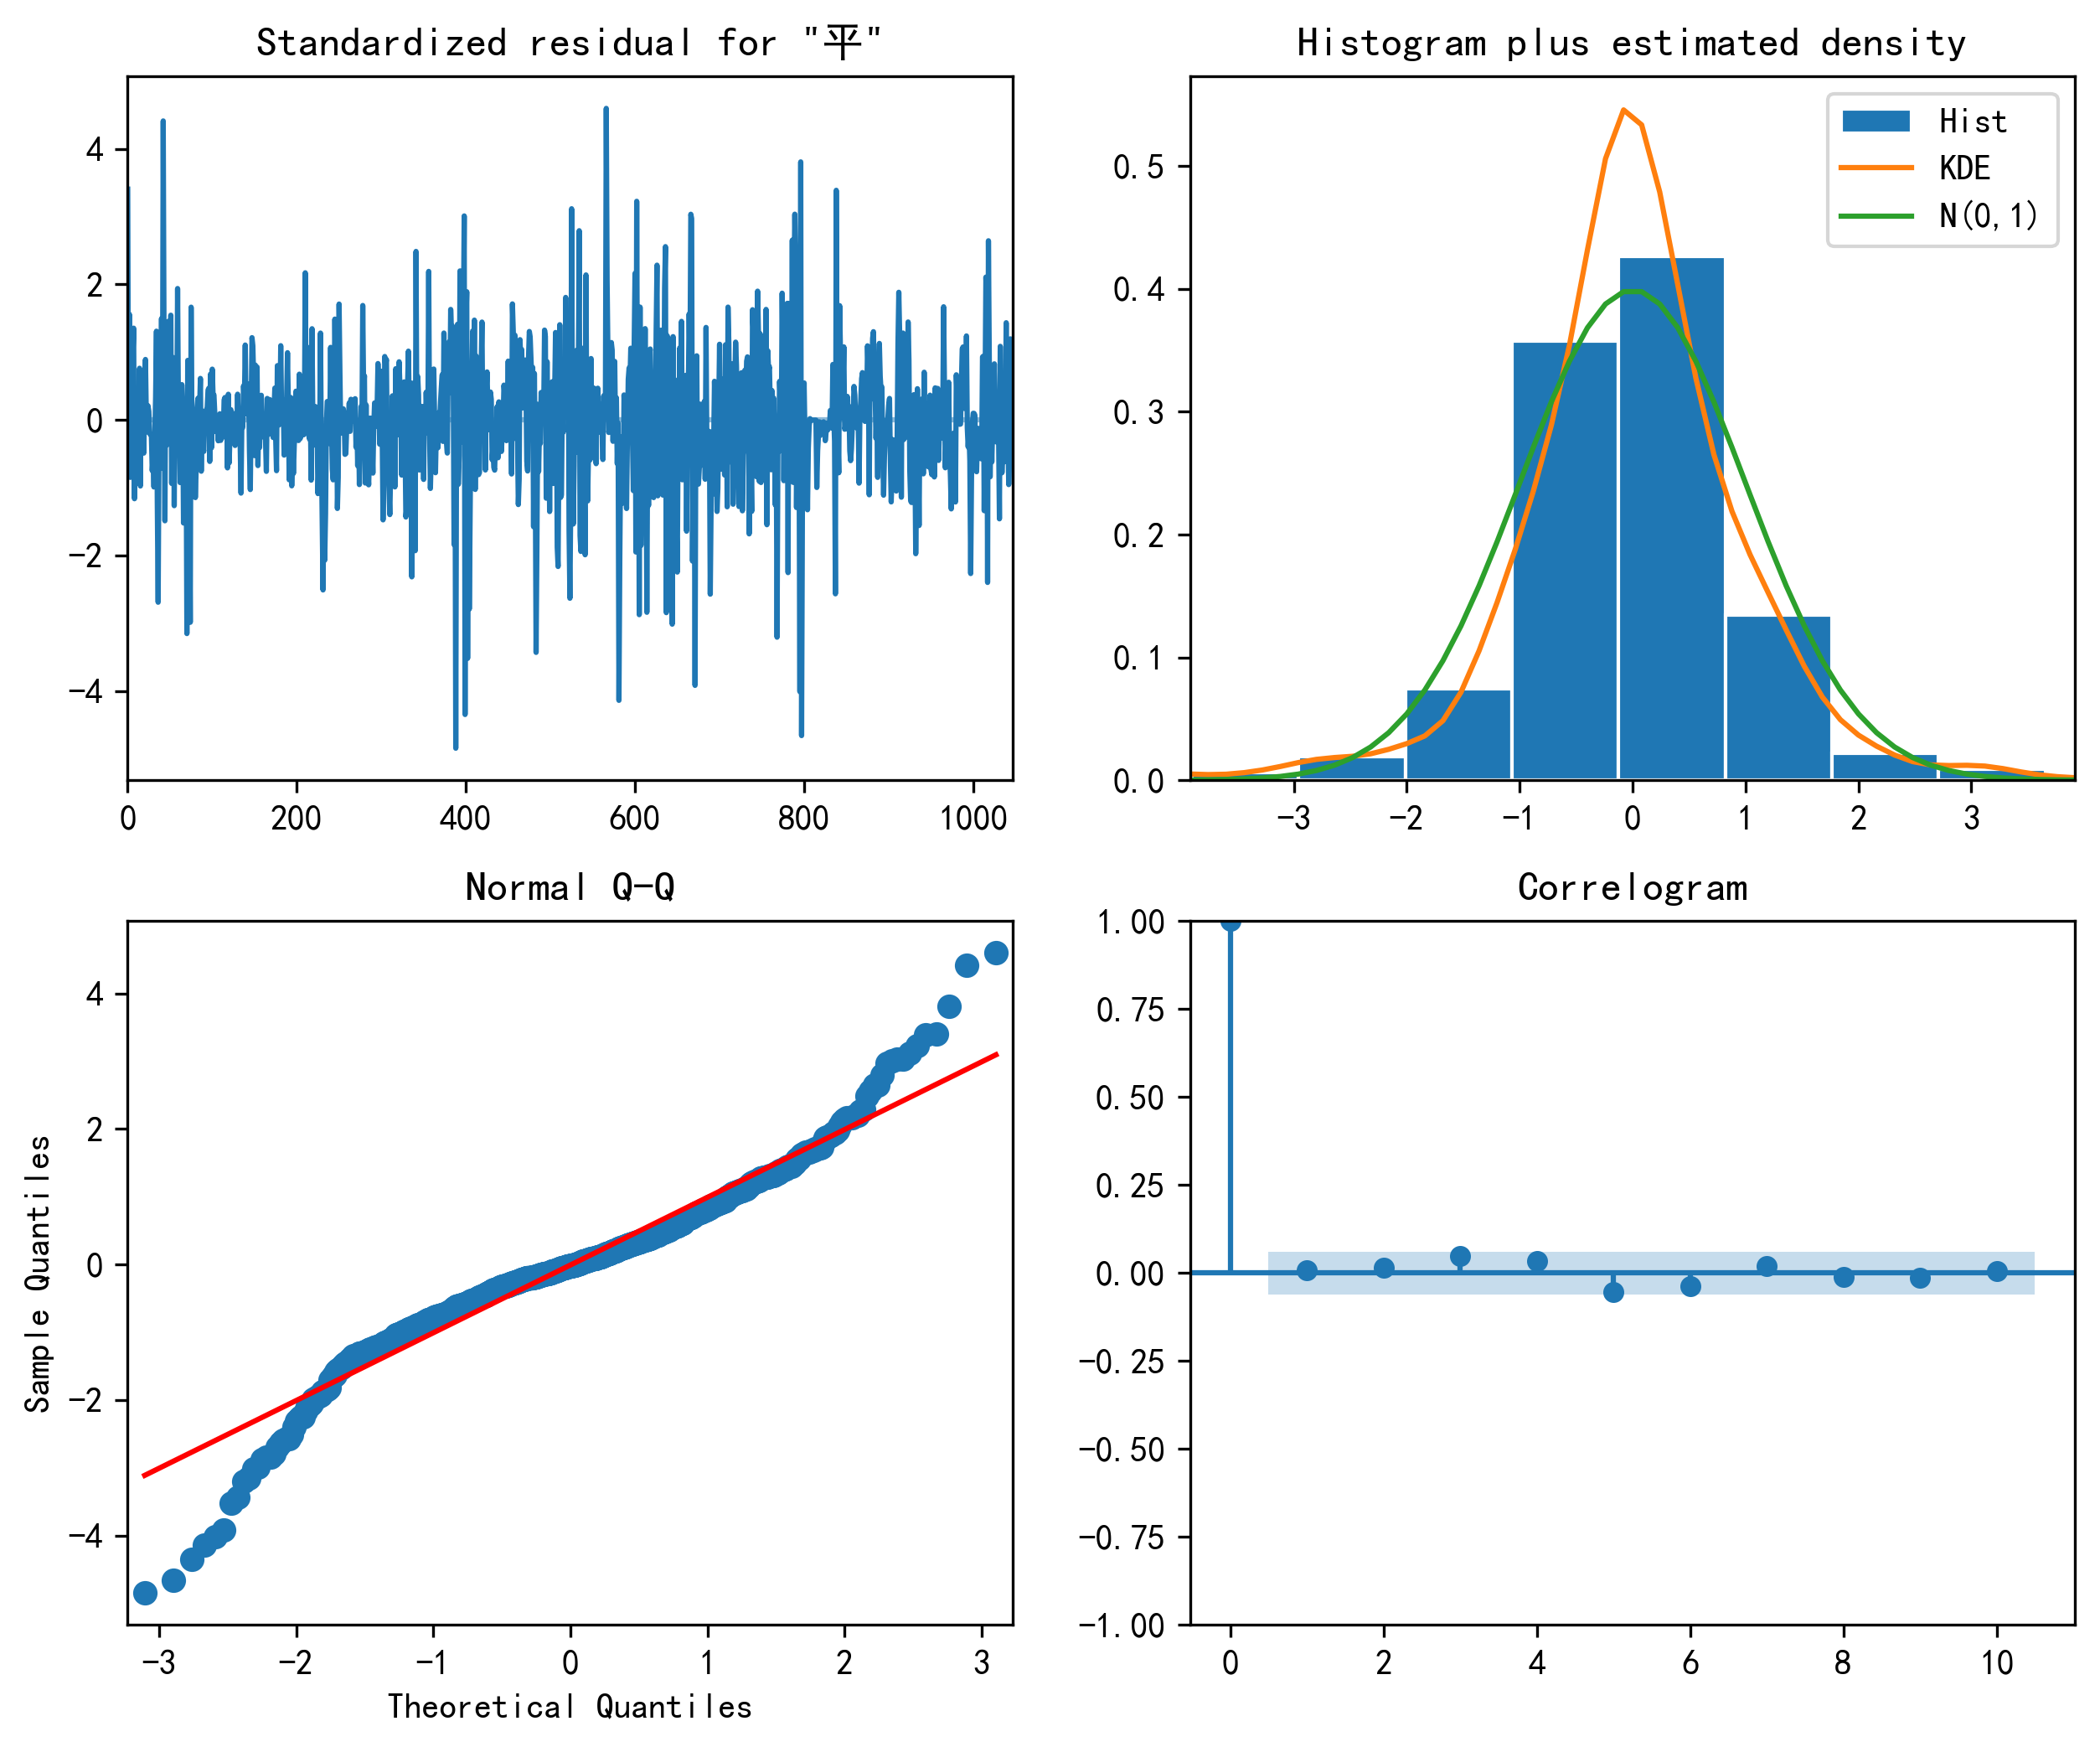

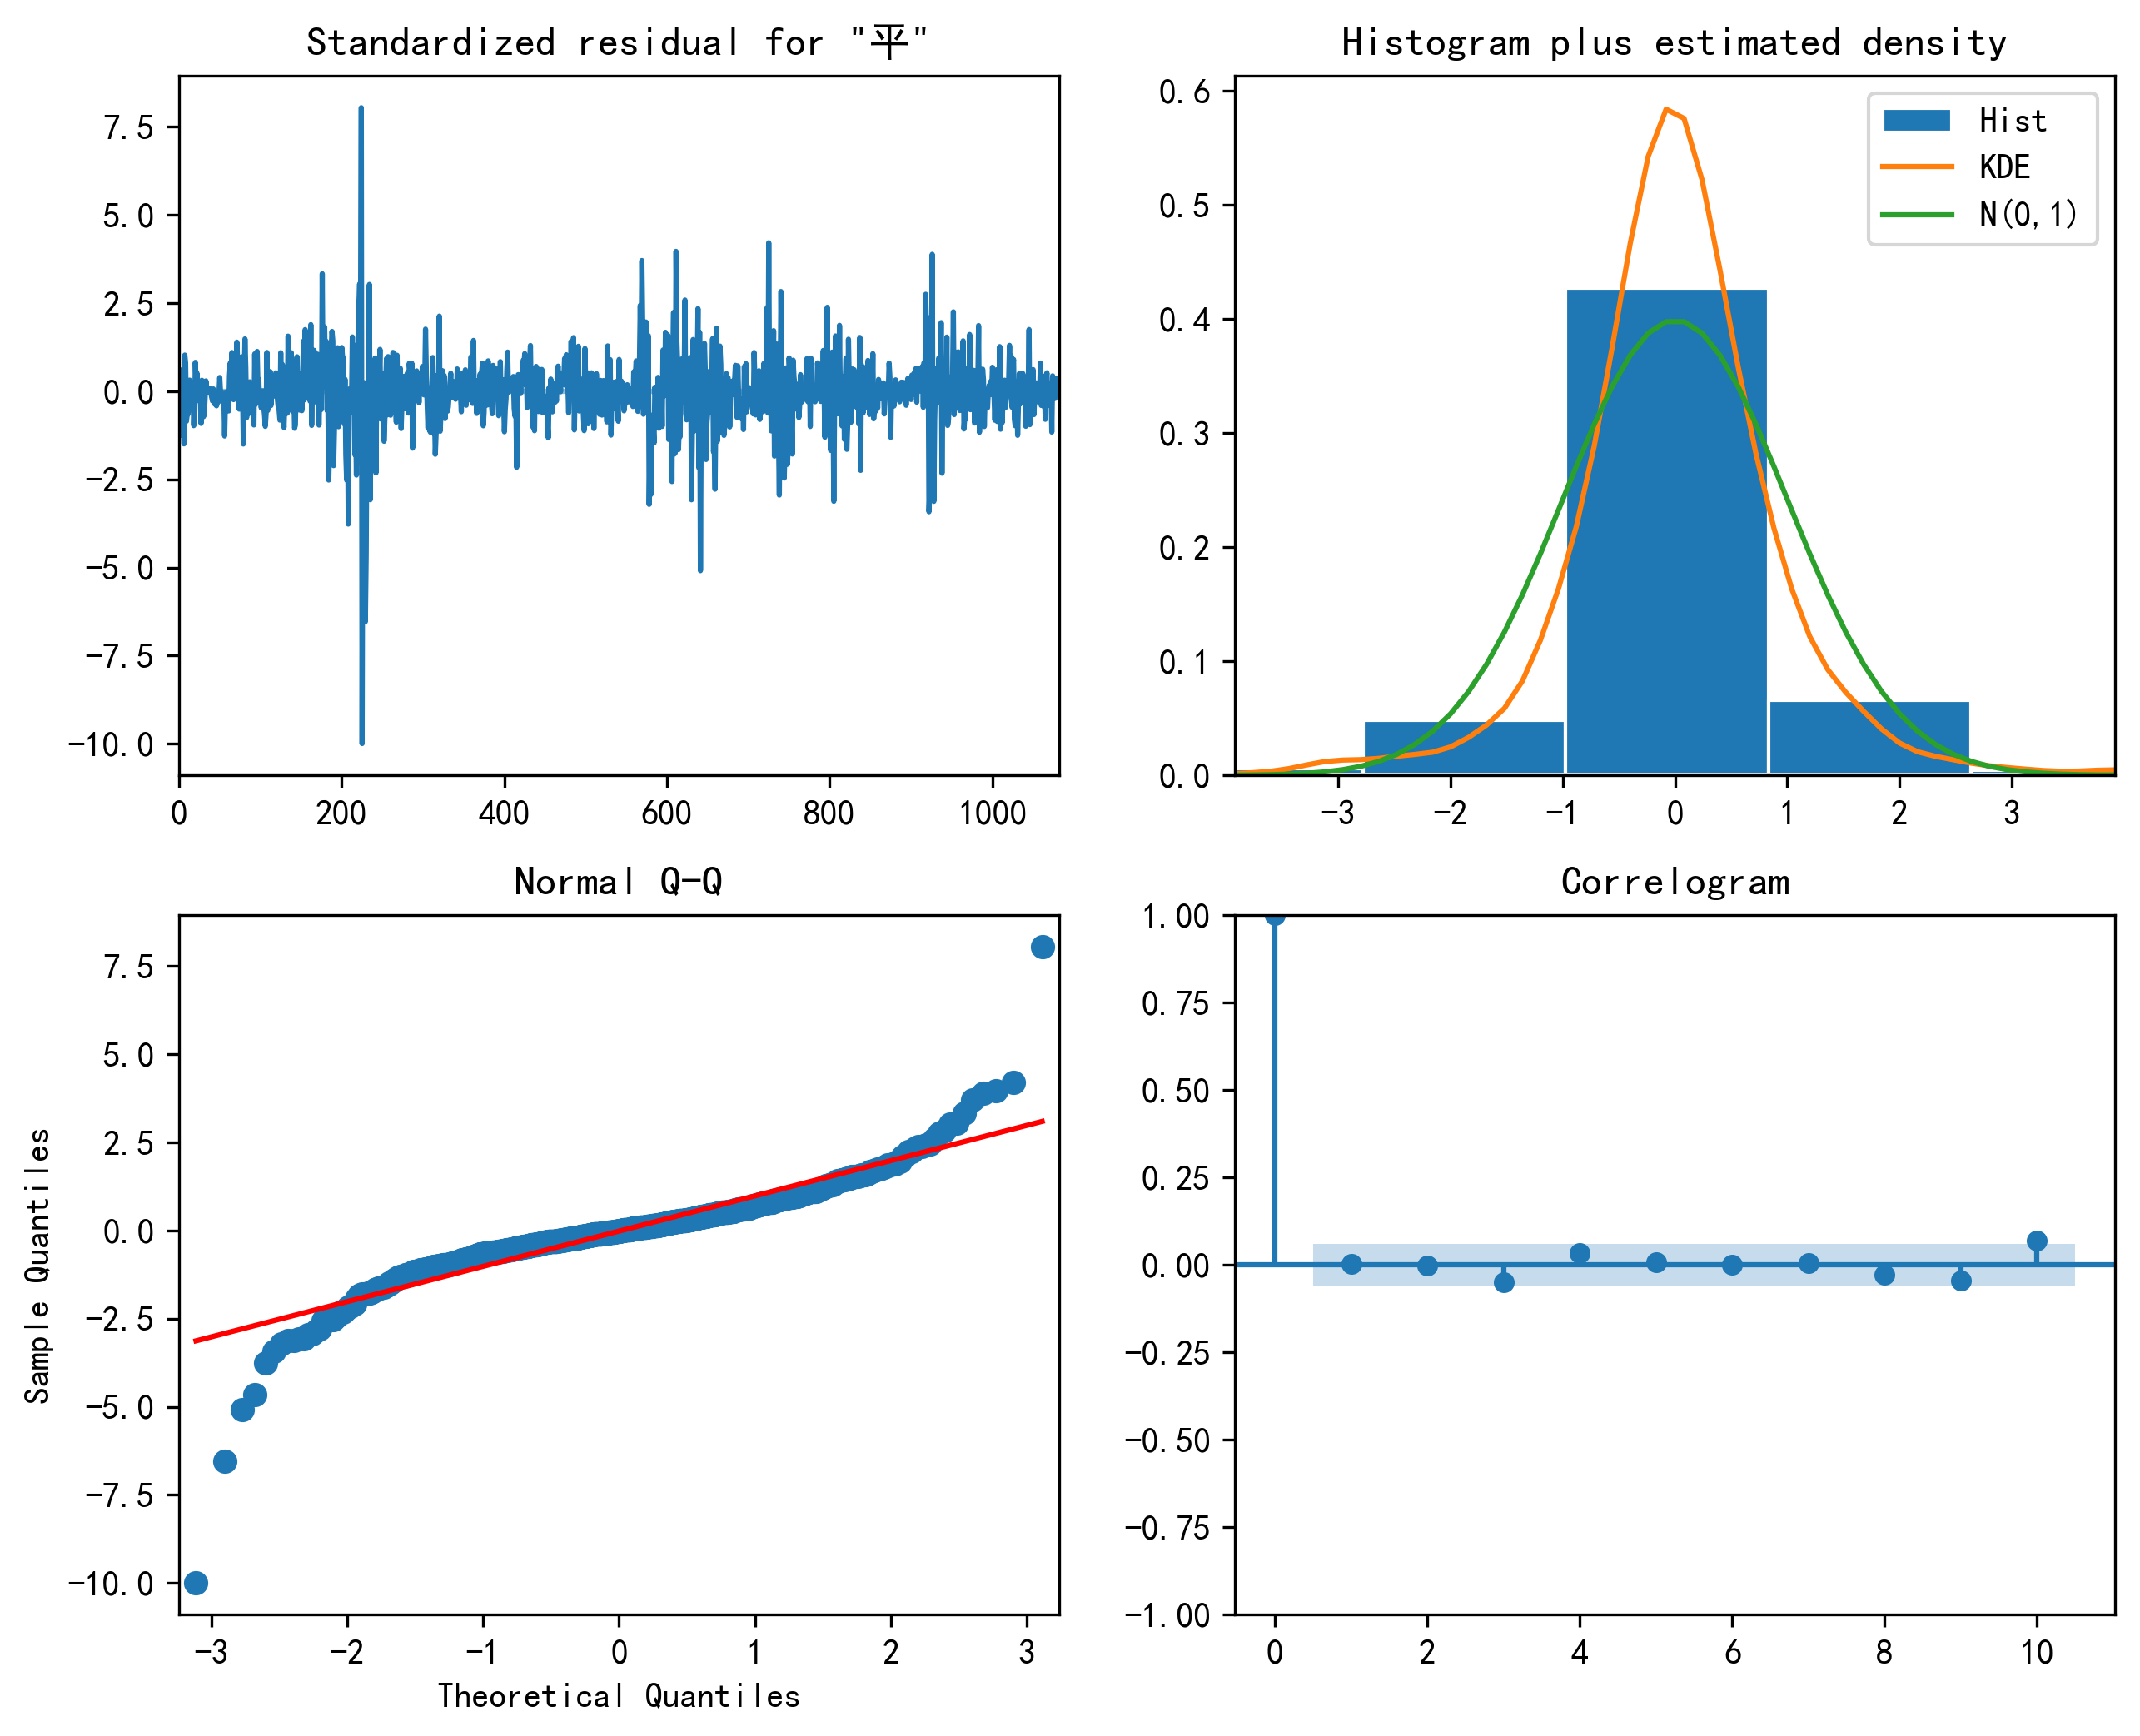

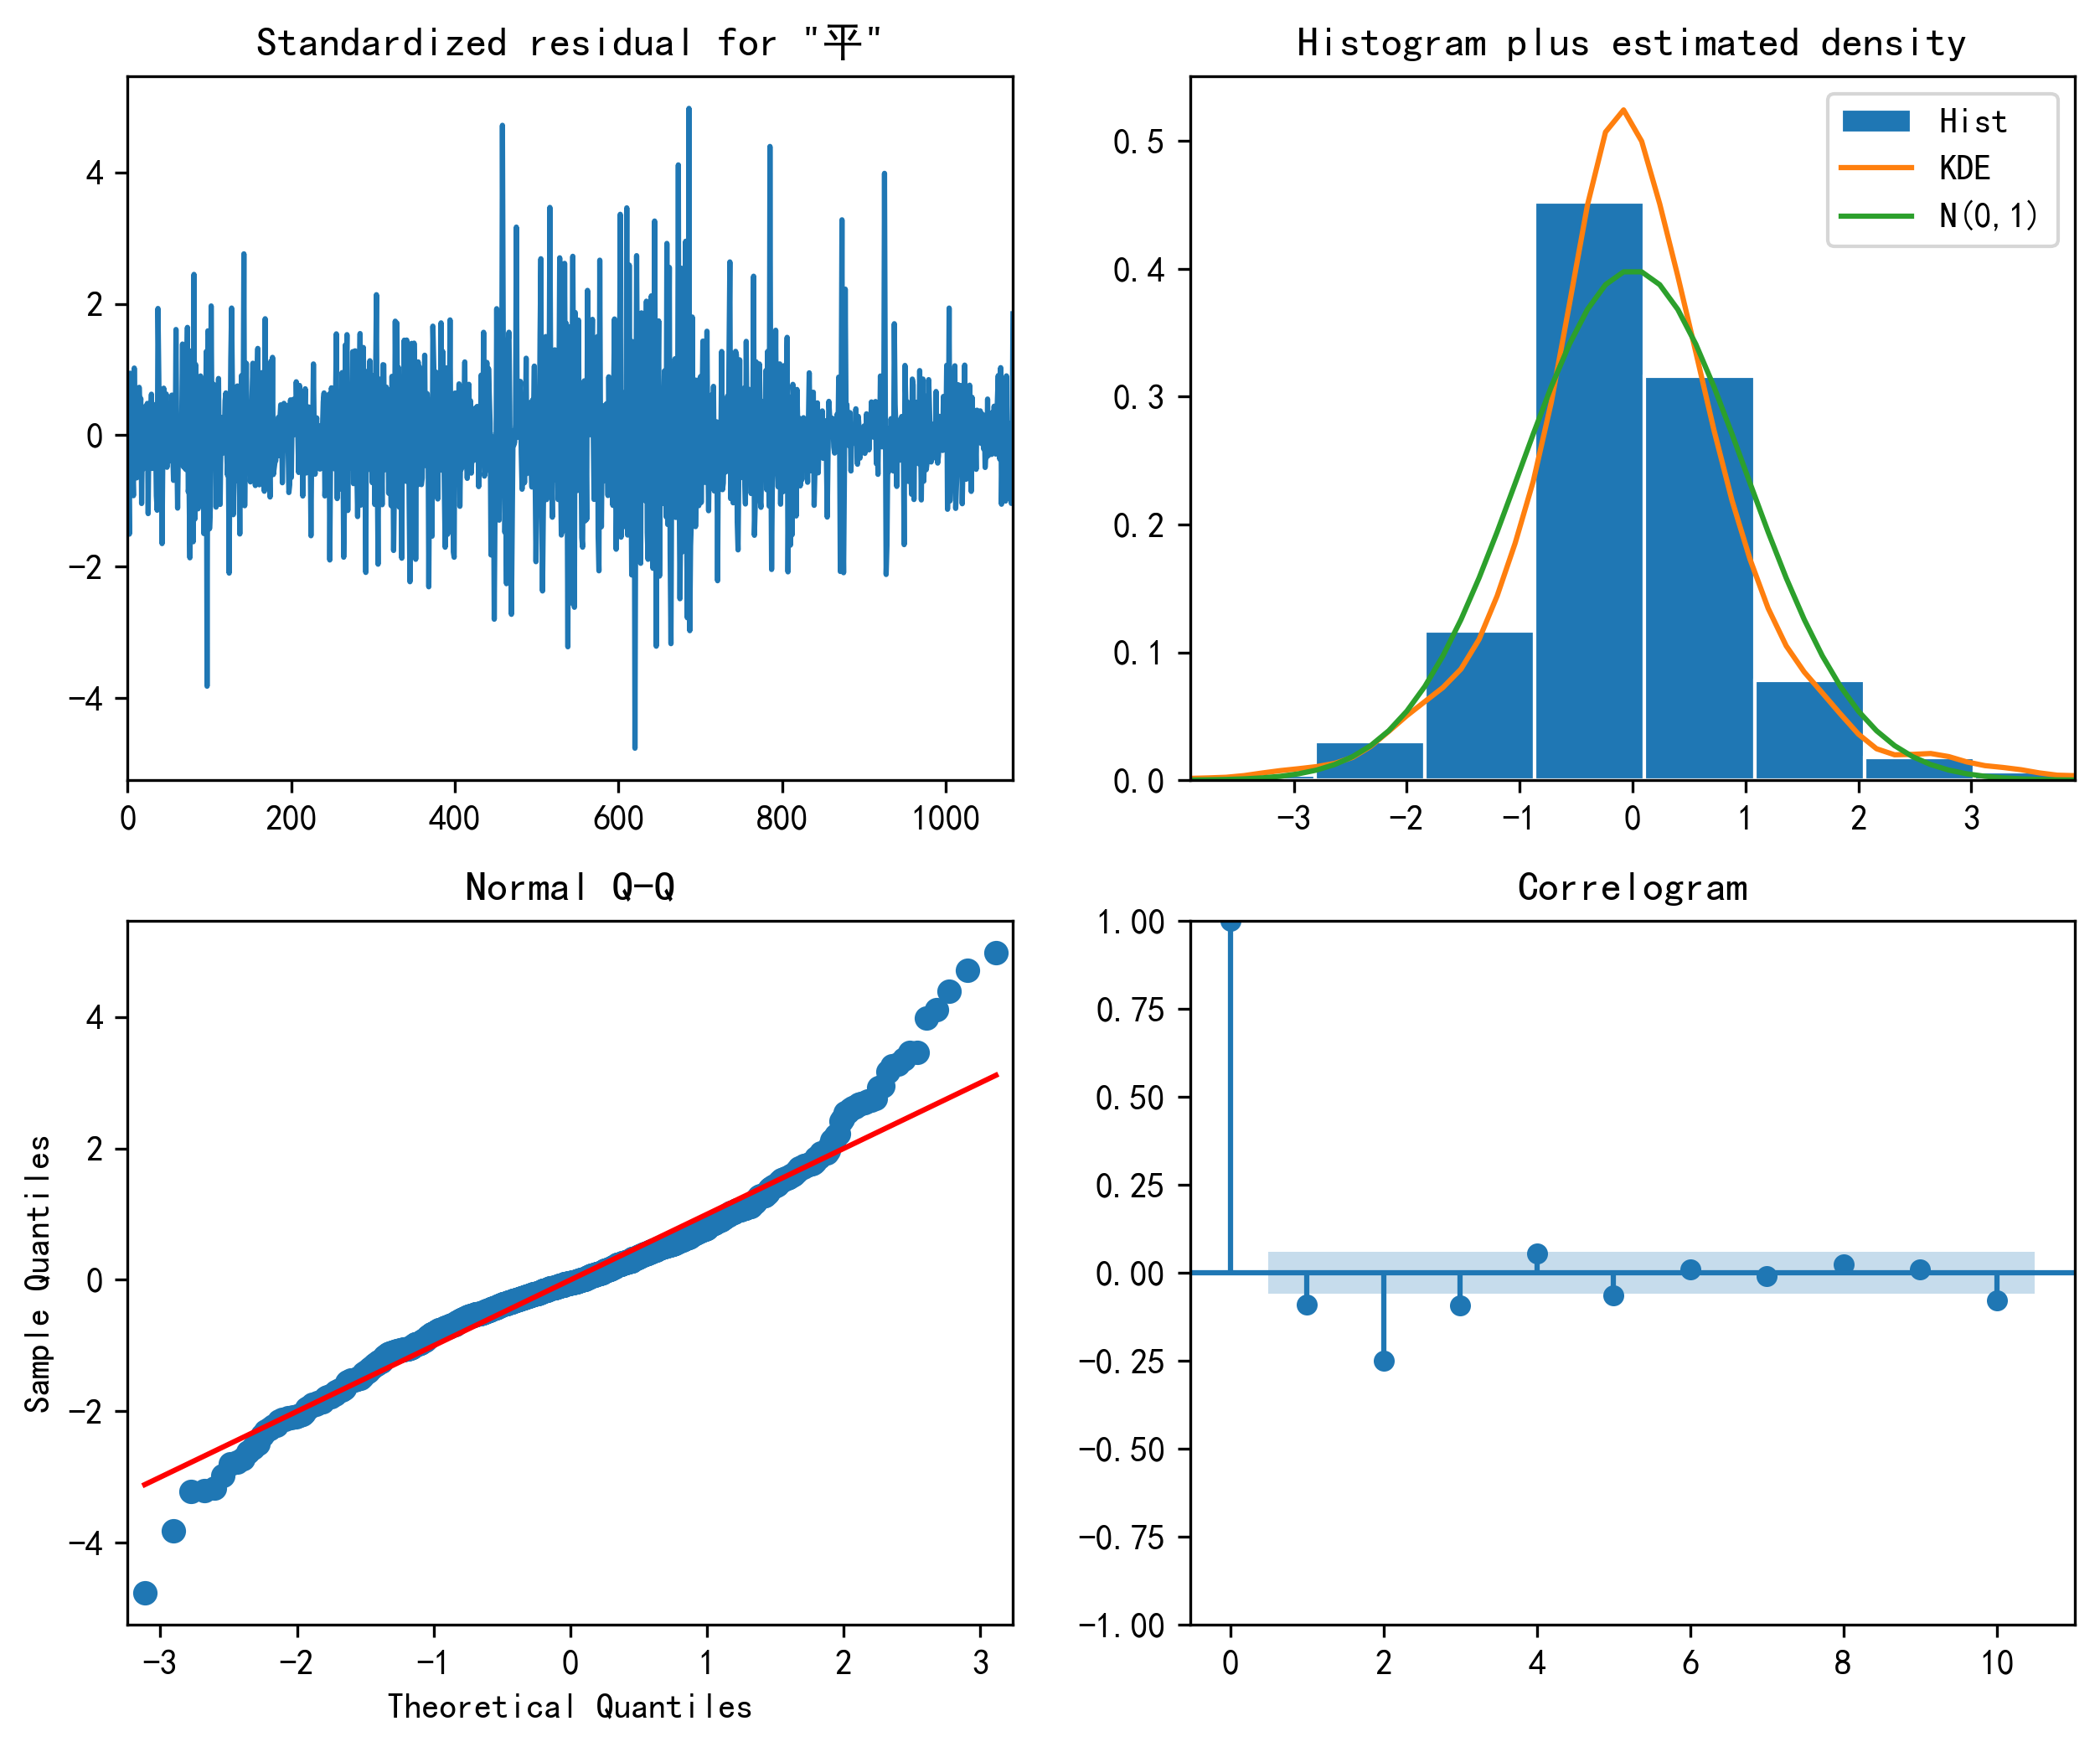

In [20]:
from statsmodels.tsa.arima.model import ARIMA
#order_list = [(0,1,0), (1,1,1), (1,2,1), (2,2,1),(2,2,2)]
# 对每个品类分别进行预测
veg_pre = pd.DataFrame()
for category in avg_wholesale_price_df['分类名称'].unique():
    # 获取该品类的数据
    category_data = avg_wholesale_price_df[avg_wholesale_price_df['分类名称'] == category]['平均批发价格']
    # 拟合ARIMA模型
    model = ARIMA(category_data, order=(2,2,2))
    model_fit = model.fit()
    # Set figure size and DPI
    plt.rcParams['figure.figsize'] = [10, 8]
    plt.rcParams['figure.dpi'] = 300
    model_fit.plot_diagnostics()
    plt.savefig(f'{category}_ARIMA模型诊断.png', dpi=300, bbox_inches='tight')
    # 存储当前参数和AIC
    record = [category, (2,2,2), model_fit.aic]
    # 进行未来7天的预测
    forecast = model_fit.forecast(steps=7)
    # 存储forecast到一个dataframe中，列名为category、日期和预测价格
    forecast_df = pd.DataFrame(forecast)
    forecast_df['category'] = category
    forecast_df['date'] = pd.date_range(start=avg_wholesale_price_df.index.max() + timedelta(days=1), periods=7, freq='D')
    forecast_df = forecast_df.set_index('date')
    forecast_df.columns = ['预测价格', 'category']
    veg_pre = pd.concat([veg_pre, forecast_df], axis=0)

In [21]:
veg_pre

,预测价格,category
date,,
2023-07-01,11.597376,水生根茎类
2023-07-02,11.604402,水生根茎类
2023-07-03,11.697496,水生根茎类
2023-07-04,11.713658,水生根茎类
2023-07-05,11.726247,水生根茎类
2023-07-06,11.732146,水生根茎类
2023-07-07,11.736842,水生根茎类
2023-07-01,3.146839,花叶类
2023-07-02,3.132347,花叶类


# 2.2 构建销售量和销售单价的关系模型

In [22]:
avg_wholesale_price_df

,分类名称,平均批发价格,平均销售价格,销售量,weekday
销售日期,,,,,
2020-07-01,水生根茎类,9.234161,14.491505,4.850,2
2020-07-02,水生根茎类,7.093748,11.548000,4.600,3
2020-07-03,水生根茎类,5.610000,10.000000,4.410,4
2020-07-04,水生根茎类,14.015119,21.833646,5.439,5
2020-07-05,水生根茎类,5.420000,10.000000,4.019,6
...,...,...,...,...,...
2023-06-26,食用菌,4.218664,6.564716,27.582,0
2023-06-27,食用菌,4.226498,6.565738,25.708,1
2023-06-28,食用菌,3.086181,4.683004,51.742,2


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 定义线性函数
def linear_func(x, a, b):
    return a * x + b

# 定义对数函数
def log_func(x, a, b, c):
    return a * np.log(x-b) + c

# 定义幂函数
def power_func(x, a, b, c, d):
    return a * np.power((x-b), -c) + d

def calculate_r_squared(y, y_pred):
    residuals = y - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# 获取某个蔬菜品类的数据
best_params_df = pd.DataFrame(columns=['分类名称', '模型名称', '模型参数'])
for category in avg_wholesale_price_df['分类名称'].unique():
    data = avg_wholesale_price_df[avg_wholesale_price_df['分类名称'] == category]
    data.sort_values(by = '平均销售价格', inplace = True)
    # 拟合线性函数
    popt_linear, pcov_linear = curve_fit(linear_func, data['平均销售价格'], data['销售量'])
    r_squared_linear = calculate_r_squared(data['销售量'], linear_func(data['平均销售价格'], *popt_linear))
    print(f'{category}的线性函数拟合优度为{r_squared_linear}')
    best_model = ('线性函数', popt_linear, r_squared_linear)
    
    # 拟合对数函数
    try:
        popt_log, pcov_log = curve_fit(log_func, data['平均销售价格'], data['销售量'])
        r_squared_log = calculate_r_squared(data['销售量'], log_func(data['平均销售价格'], *popt_log))
        print(f'{category}的对数函数拟合优度为{r_squared_log}')
        if r_squared_log > best_model[2]:
            best_model = ('对数函数', popt_log, r_squared_log)
    except:
        r_squared_log = -1
        print(f'{category}的对数函数拟合优度为0')

    # 拟合幂函数
    try:
        popt_power, pcov_power = curve_fit(power_func, data['平均销售价格'], data['销售量'])
        r_squared_power = calculate_r_squared(data['销售量'], power_func(data['平均销售价格'], *popt_power))
        print(f'{category}的幂函数拟合优度为{r_squared_power}')
        if r_squared_power > best_model[2]:
            best_model = ('幂函数', popt_power, r_squared_power)
    except:
        r_squared_power = -1
        print(f'{category}的幂函数拟合优度为0')

    # 将最佳模型参数存储到DataFrame中
    #best_params_df = pd.concat({'分类名称': category, '模型名称': best_model[0], '模型参数': best_model[1]}, ignore_index=True)
# 创建一个新的 Series 来存储数据  
    new_row = pd.Series({'分类名称': category, '模型名称': best_model[0], '模型参数': best_model[1]})  
# 将新的 Series 添加到 DataFrame 中  
    best_params_df.loc[len(best_params_df)] = new_row   
print(best_params_df)

水生根茎类的线性函数拟合优度为0.11745080069648461
水生根茎类的对数函数拟合优度为0.12923451930385366
水生根茎类的幂函数拟合优度为1.0
花叶类的线性函数拟合优度为0.044656284163110516
花叶类的对数函数拟合优度为0.06654722980518557
花叶类的幂函数拟合优度为1.0
花菜类的线性函数拟合优度为0.10025714280460707
花菜类的对数函数拟合优度为0
花菜类的幂函数拟合优度为1.0
茄类的线性函数拟合优度为0.03763208851021638
茄类的对数函数拟合优度为0.05244971750068983
茄类的幂函数拟合优度为0.0
辣椒类的线性函数拟合优度为0.02222875889460274
辣椒类的对数函数拟合优度为0.06447516978371415
辣椒类的幂函数拟合优度为-2.220446049250313e-16
食用菌的线性函数拟合优度为0.025661297021104756
食用菌的对数函数拟合优度为0
食用菌的幂函数拟合优度为0
    分类名称  模型名称                                               模型参数
0  水生根茎类   幂函数                               [nan, nan, nan, nan]
1    花叶类   幂函数                               [nan, nan, nan, nan]
2    花菜类   幂函数                               [nan, nan, nan, nan]
3     茄类  对数函数  [-8.161772412847561, 1.623671991416281, 36.470...
4    辣椒类  对数函数  [-17.07560032624417, 3.108166069043926, 105.16...
5    食用菌  线性函数            [-3.2887802512325504, 92.5373263757998]


In [37]:
best_params_df.drop_duplicates(subset='分类名称', keep='last', inplace=True)
# best_params_df.to_csv('最佳模型参数.csv', index=False)
# best_params_df = pd.read_csv('最佳模型参数1.csv')
best_params_df

,分类名称,模型名称,模型参数
0,水生根茎类,对数函数,[-26.11035516 2.51727164 83.60511972]
1,花叶类,对数函数,[-36.00775817 2.35435122 209.756959 ]
2,花菜类,线性函数,[-2.89165146 64.2021206 ]
3,茄类,对数函数,[-8.16177241 1.62367199 36.4701182 ]
4,辣椒类,对数函数,[-17.07560033 3.10816607 105.16379865]
5,食用菌,线性函数,[-3.28878025 92.53732638]


# 2.3 构建规划模型，最大化超市利益

利润: y = x_2 * power_func(x_2, *popt_power) - x_3 * x_1

日补货量为x_1： x_1 >= power_func(x_2, *popt_power) + x_1 * x_4

日成本定价为x_2： x_2 > x_3

日批发价为x_3： x_3 = veg_pre.iloc[0,0]

平均损耗率为x_4： x_4 = merged_data[merged_data['分类名称'] == category]['平均损耗率'].values[0]

In [41]:
def plan_model(category, veg_pre, merged_data, func, day, log):

    # 定义目标函数和约束条件函数
    x3 = veg_pre[veg_pre['category'] == category].iloc[day].values[0]
    def objective(individual):
        x1, x2 = individual
        x3 = veg_pre[veg_pre['category'] == category].iloc[day].values[0]
        return - (x2 * func(x2, *log) - x3 * x1)

    def constraint(individual):
        x1, x2 = individual
        x3 = veg_pre[veg_pre['category'] == category].iloc[day].values[0]
        x4 = merged_data[merged_data['分类名称'] == category]['平均损耗率'].values[0] / 100
        return [x1 - func(x2, *log) - x1 * x4, x2 - x3, x2]

    # 定义可行性函数
    def feasible(individual):
        cons = constraint(individual)
        return all(c >= 0 for c in cons)

    bounds = [(0, 10000), (x3, 3 * x3)]
    x0 = [50, x3 + 0.001]
    res = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints={'type': 'ineq', 'fun': constraint})

    x1, x2 = res.x
    # 输出结果
    return x1, x2

In [44]:
result_df = pd.DataFrame(columns=['日期', '类别', '进货量', '定价'])

for category in avg_wholesale_price_df['分类名称'].unique():
    model_name = best_params_df[best_params_df['分类名称'] == category]['模型名称']
    model_log = best_params_df[best_params_df['分类名称'] == category]['模型参数'].values[0]
    if (model_name == '线性函数').values[0]:
        def func(x, a, b):
            return a * x + b
    if (model_name == '对数函数').values[0]:
        def func(x, a, b, c):
            return a * np.log(x-b) + c
    if (model_name == '幂函数').values[0]:
        def func(x, a, b, c, d):
            return a * np.power((x-b), -c) + d

    for day in range(7):
        x1, x2 = plan_model(category, veg_pre, merged_data, func, day, model_log)
        new_row = pd.DataFrame({'日期': [day+1], '类别': [category], '进货量': [x1], '定价': [x2]})  
# 将新的 DataFrame 与原有的 DataFrame 合并  
        result_df = pd.concat([result_df, new_row], ignore_index=True)  

TypeError: func() takes 4 positional arguments but 39 were given

In [ ]:
result_df.to_csv('plan_result_problem2.csv', index=False)